In [2]:
# load faces
if yalefaces:
    labels, faces = zip(*[(f.split('/')[1].split('.')[0], pylab.imread(f)) for f in allfiles])
else:
    labels, faces = zip(*[(f.rsplit('/',1)[1].rsplit('_',1)[0], pylab.imread(f)) for f in allfiles])  
allfaces = np.vstack([x.reshape(1,np.prod(x.shape)) for x in faces])

In [3]:
# center faces
meanface = np.mean(allfaces,0)
centeredfaces = allfaces-meanface
if yalefaces:
    [U,S,V]=np.linalg.svd(centeredfaces,0) # compute eigenvalues/eigenvectors (aka components)
else:
    [U,S,V]=np.linalg.svd(centeredfaces[:3000,:],0) # compute eigenvalues/eigenvectors (aka components)
print V.shape

(165, 77760)


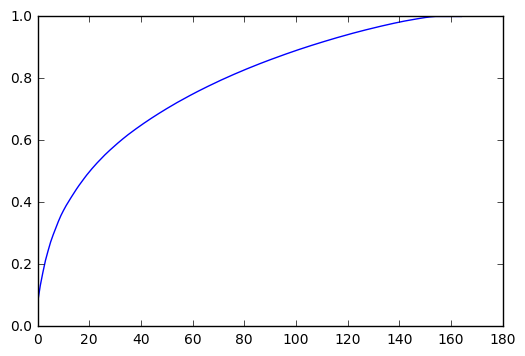

In [4]:
# View recovered variance
varacc = np.cumsum(S)/sum(S)
plot(np.arange(varacc.shape[0]), varacc)
show()

In [2]:
%pylab inline
import numpy as np
from glob import glob
import urllib, os
yalefaces = True
if yalefaces:
    if not os.path.exists('./yalefaces'):
        # get dataset. Assuming unzip command installed
        url = 'http://www.cs.princeton.edu/courses/archive/spr04/cos429/images/yalefaces.zip'
        fname = urllib.urlretrieve(url)[0]
        os.system('unzip '+fname)
    allfiles = glob('yalefaces/subject*')
else:
    if not os.path.exists('./lfwcrop'):
        # get dataset. Assuming unzip command installed
        url = 'http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip'
        fname = urllib.urlretrieve(url)[0]
        os.system('unzip '+fname)
    allfiles = glob('lfwcrop_grey/faces/*.pgm')
print len(allfiles)
print allfiles[:5]

Populating the interactive namespace from numpy and matplotlib
165
['yalefaces/subject07.happy', 'yalefaces/subject12.happy', 'yalefaces/subject12.normal', 'yalefaces/subject03.wink', 'yalefaces/subject14.surprised']


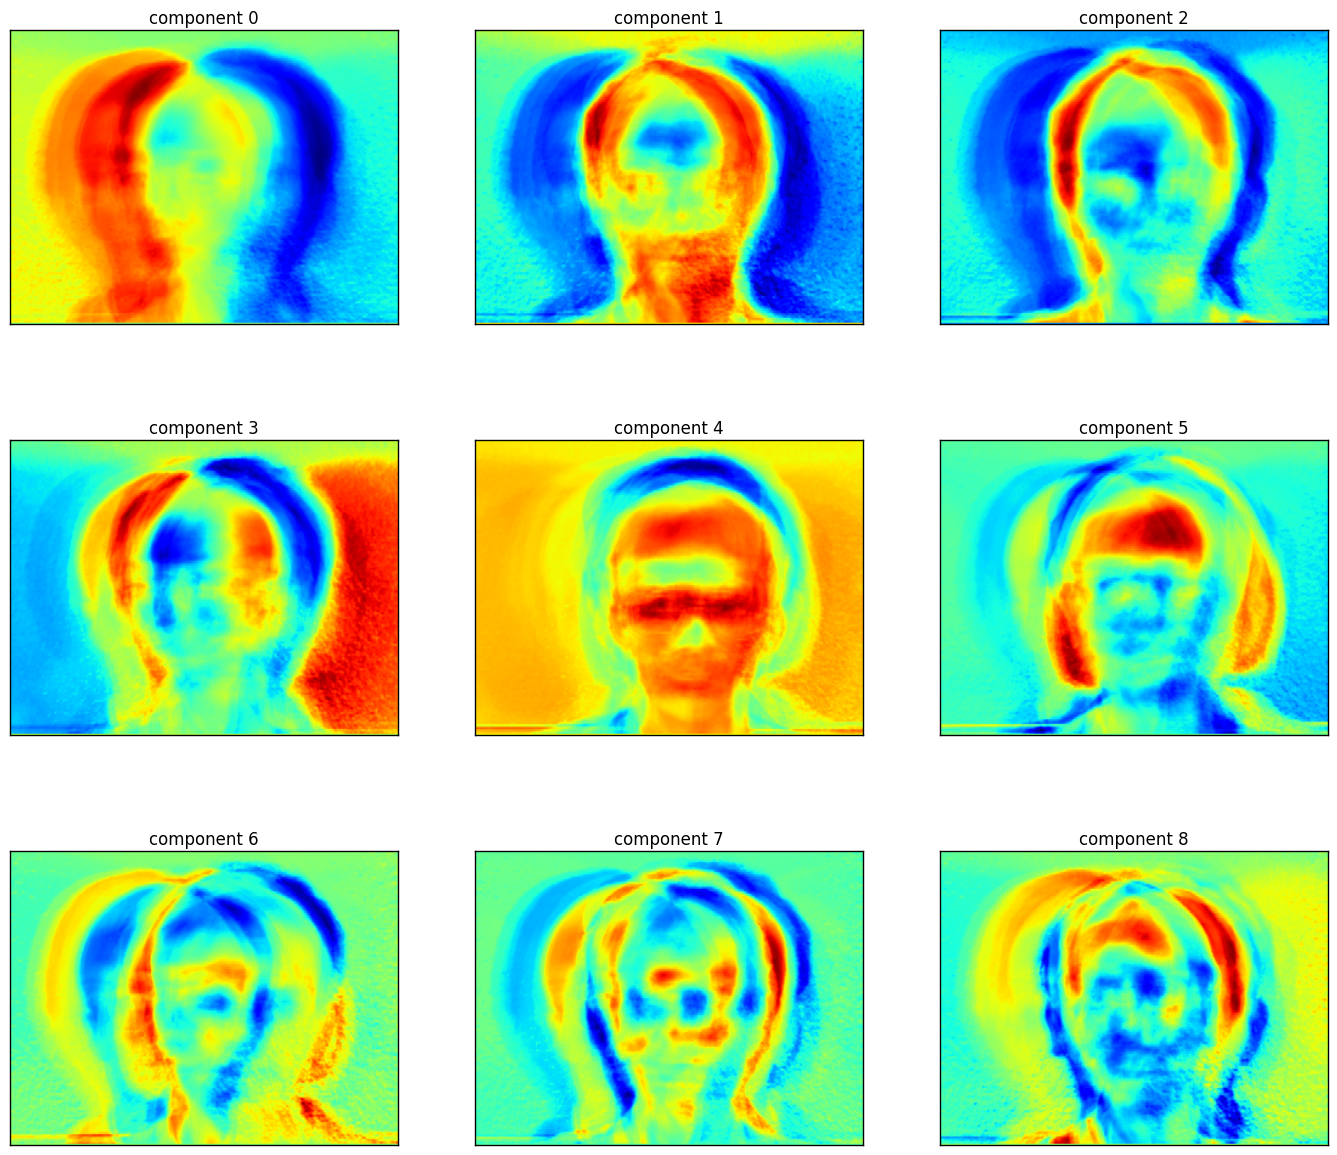

In [5]:
# show components
pylab.rcParams['figure.figsize'] = (17,15)
fig, axs = subplots(nrows=3, ncols=3)
for j in range(3):
    for i in range(3):
        axs[j,i].imshow(V[j*3+i,:].reshape(faces[0].shape))
        axs[j,i].set_title('component %d'%(j*3+i))
        axs[j,i].set_xticks([]); axs[j,i].set_yticks([])

In [6]:
# Project training data
eigenfaces = np.dot(centeredfaces, V.T)

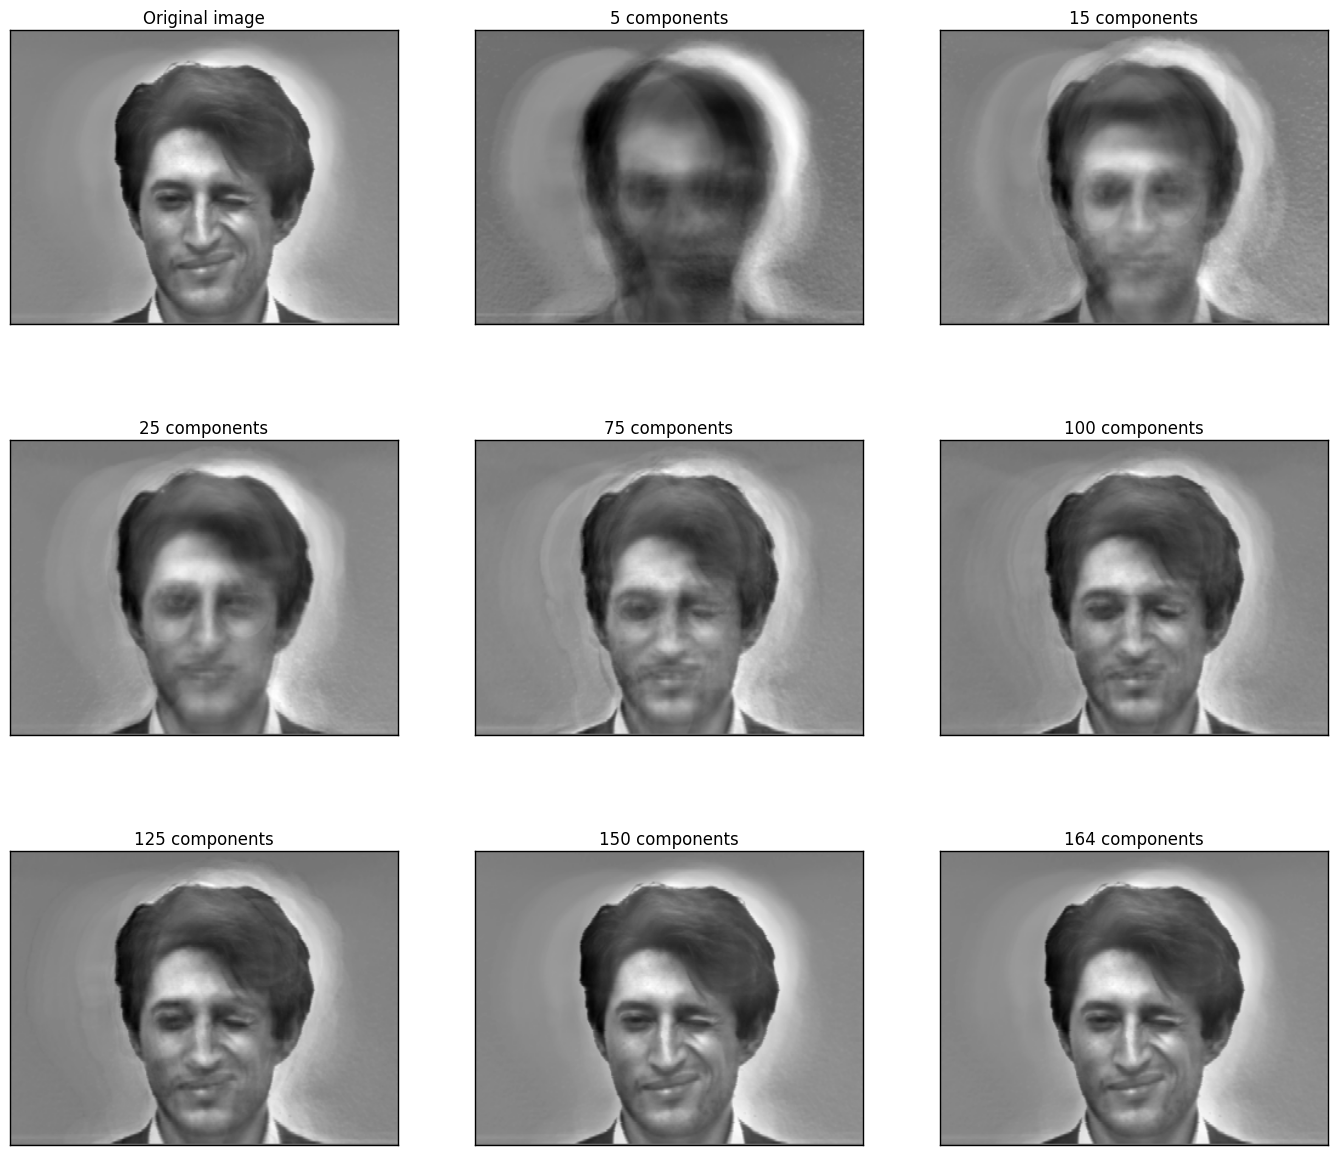

In [7]:
# Reconstruct data points
# pylab.rcParams['figure.figsize'] = (17,15)
def show_face(j, ef, comp, k, dst_shape, ax):
    reconstructed_face = np.sum(np.vstack([ef[j,i]*comp[i] for i in range(k)]),0).reshape(dst_shape)
    ax.imshow(reconstructed_face, cmap=cm.gray)
if yalefaces: rows=3
else: rows=4
fig, axs = subplots(nrows=rows, ncols=3)
for ax in axs.flatten():
    ax.set_xticks([]); ax.set_yticks([])
f=3 # doing face ...
axs[0,0].imshow(centeredfaces[f,:].reshape(faces[0].shape), cmap=cm.gray); axs[0,0].set_title('Original image')
k=5;   show_face(f, eigenfaces, V, k, faces[0].shape, axs[0,1]); axs[0,1].set_title('%d components'%k)
k=15;  show_face(f, eigenfaces, V, k, faces[0].shape, axs[0,2]); axs[0,2].set_title('%d components'%k)
k=25;  show_face(f, eigenfaces, V, k, faces[0].shape, axs[1,0]); axs[1,0].set_title('%d components'%k)
k=75;  show_face(f, eigenfaces, V, k, faces[0].shape, axs[1,1]); axs[1,1].set_title('%d components'%k)
k=100; show_face(f, eigenfaces, V, k, faces[0].shape, axs[1,2]); axs[1,2].set_title('%d components'%k)
k=125; show_face(f, eigenfaces, V, k, faces[0].shape, axs[2,0]); axs[2,0].set_title('%d components'%k)
k=150; show_face(f, eigenfaces, V, k, faces[0].shape, axs[2,1]); axs[2,1].set_title('%d components'%k)
k=164; show_face(f, eigenfaces, V, k, faces[0].shape, axs[2,2]); axs[2,2].set_title('%d components'%k)
if not yalefaces:
    k=200; show_face(f, eigenfaces, V, k, faces[0].shape, axs[3,0]); axs[3,0].set_title('%d components'%k)
    k=300; show_face(f, eigenfaces, V, k, faces[0].shape, axs[3,1]); axs[3,1].set_title('%d components'%k)
    k=500; show_face(f, eigenfaces, V, k, faces[0].shape, axs[3,2]); axs[3,2].set_title('%d components'%k)

In [8]:
from scipy.spatial.distance import cdist
from collections import Counter
def knn(k, query, alldata, labels):
    dists = cdist(query, alldata)
    rank = np.argsort(dists[0])
    votes = Counter([labels[i] for i in rank[1:k+1]]) # ignoring 0th since will be itself
    return votes.most_common(1)

acc_original=[]
acc_pca = []
k=3
for i in range(min(3000, len(labels))):
    acc_original.append(knn(k, centeredfaces[i:i+1,:], centeredfaces[:3000,:], labels)[0][0]==labels[i])
print '"Original" (%d "components") accuracy = %.4f'%(centeredfaces.shape[1],100*sum(acc_original)/float(len(acc_original)))

"Original" (77760 "components") accuracy = 78.7879


In [9]:
for n_comp in [1,5,10,25,35,50,75,100]:
    acc_pca=[]
    for i in range(len(labels)):
        acc_pca.append(knn(k, eigenfaces[i:i+1,:n_comp], eigenfaces[:3000,:n_comp], labels)[0][0]==labels[i])
    print '"PCAed" accuracy with %d components = %.4f'%(n_comp,100.0*sum(acc_pca)/len(acc_pca))

"PCAed" accuracy with 1 components = 27.8788
"PCAed" accuracy with 5 components = 66.6667
"PCAed" accuracy with 10 components = 72.1212
"PCAed" accuracy with 25 components = 76.9697
"PCAed" accuracy with 35 components = 78.1818
"PCAed" accuracy with 50 components = 80.0000
"PCAed" accuracy with 75 components = 79.3939
"PCAed" accuracy with 100 components = 78.7879


In [10]:
acc_original = []
for i in range(len(labels)):
    acc_original.append(knn(k, centeredfaces[i:i+1,242*320:243*320], centeredfaces[:,242*320:243*320], labels)[0][0]==labels[i])
print '"Original center line" (%d "components") accuracy = %.4f'%(faces[0].shape[1],100*sum(acc_original)/float(len(acc_original))) 

"Original center line" (320 "components") accuracy = 6.6667
